In [186]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Data Loading and Preprocessing

In [187]:
df = pd.read_csv('Final.tsv' , sep='\t')

In [188]:
df.head()

,Unnamed: 0,Study ID,Patient ID,Sample ID,Cancer Type,Cancer Type Detailed,Ethnicity,Fraction Genome Altered,Gene Panel,Metastatic Site,...,Primary Tumor Site,Race,Sample Class,Number of Samples Per Patient,Sample coverage,Sample Type,Sex,Somatic Status,TMB (nonsynonymous),Tumor Purity
0,0,pancreas_msk_2024,P-0000142,P-0000142-T01-IM3,Pancreatic Cancer,Pancreatic Adenocarcinoma,Non-Spanish; Non-Hispanic,0.2681,IMPACT341,NaN,...,Pancreas,WHITE,Tumor,1,639,Primary,Female,Matched,4.436621,40.0
1,1,pancreas_msk_2024,P-0002230,P-0002230-T01-IM3,Pancreatic Cancer,Pancreatic Adenocarcinoma,Non-Spanish; Non-Hispanic,0.0000,IMPACT341,NaN,...,Pancreas,WHITE,Tumor,1,701,Primary,Female,Matched,2.218311,50.0
2,2,pancreas_msk_2024,P-0002704,P-0002704-T01-IM3,Pancreatic Cancer,Pancreatic Adenocarcinoma,Non-Spanish; Non-Hispanic,0.0632,IMPACT341,NaN,...,Pancreas,WHITE,Tumor,1,191,Primary,Female,Matched,0.000000,20.0
3,3,pancreas_msk_2024,P-0003006,P-0003006-T01-IM3,Pancreatic Cancer,Pancreatic Adenocarcinoma,Non-Spanish; Non-Hispanic,0.0000,IMPACT341,NaN,...,Pancreas,WHITE,Tumor,1,680,Primary,Male,Matched,4.436621,20.0
4,4,pancreas_msk_2024,P-0003540,P-0003540-T01-IM5,Pancreatic Cancer,Pancreatic Adenocarcinoma,Non-Spanish; Non-Hispanic,0.0175,IMPACT410,NaN,...,Pancreas,WHITE,Tumor,1,409,Primary,Male,Matched,3.914879,20.0


In [189]:
df["Overall Survival (Months)"].describe()

count    393.000000
mean      35.814979
std       27.345184
min        0.164382
25%       13.150541
50%       27.484630
75%       52.569287
max      109.050860
Name: Overall Survival (Months), dtype: float64

In [190]:
def create_risk_labels(survival_months, status, threshold=30):
    labels = []
    for months, s in zip(survival_months, status):
        if months >= threshold:
            labels.append("Respondents ")
        elif s == 1:
            labels.append("Non-Respondents")
        else:
            labels.append("Unknown")
    return labels

In [191]:
import pandas as pd
# Calculate missing values percentage
missing_percentage = (df.isnull().sum() / len(df)) * 100

In [192]:
df.columns

Index(['Unnamed: 0', 'Study ID', 'Patient ID', 'Sample ID', 'Cancer Type',
       'Cancer Type Detailed', 'Ethnicity', 'Fraction Genome Altered',
       'Gene Panel', 'Metastatic Site', 'MSI Score', 'MSI Type',
       'Mutation Count', 'Oncotree Code', 'Overall Survival (Months)',
       'Overall Survival Status', 'Primary Tumor Site', 'Race', 'Sample Class',
       'Number of Samples Per Patient', 'Sample coverage', 'Sample Type',
       'Sex', 'Somatic Status', 'TMB (nonsynonymous)', 'Tumor Purity'],
      dtype='object')

In [193]:
print(missing_percentage.sort_values(ascending=False))

Metastatic Site                  99.746835
Tumor Purity                      1.012658
MSI Score                         1.012658
MSI Type                          1.012658
Mutation Count                    0.506329
Overall Survival (Months)         0.506329
Primary Tumor Site                0.000000
TMB (nonsynonymous)               0.000000
Somatic Status                    0.000000
Sex                               0.000000
Sample Type                       0.000000
Sample coverage                   0.000000
Number of Samples Per Patient     0.000000
Sample Class                      0.000000
Race                              0.000000
Unnamed: 0                        0.000000
Overall Survival Status           0.000000
Study ID                          0.000000
Gene Panel                        0.000000
Fraction Genome Altered           0.000000
Ethnicity                         0.000000
Cancer Type Detailed              0.000000
Cancer Type                       0.000000
Sample ID  

In [194]:
# Dropping the columns with more than 50% missing values
df = df.drop(columns=missing_percentage[missing_percentage > 50].index)

In [195]:
# columns with object type
object_columns = df.select_dtypes(include=['object']).columns.tolist()
# columns with int type
int_columns = df.select_dtypes(include=['int']).columns.tolist()
# columns with float type
float_columns = df.select_dtypes(include=['float']).columns.tolist()
# columns with bool type
bool_columns = df.select_dtypes(include=['bool']).columns.tolist()

In [196]:
from sklearn.impute import KNNImputer

# Object columns (categorical) - Fill with mode
for column in object_columns:
    df[column] = df[column].fillna(df[column].mode()[0])

# Integer columns - Use median (robust to outliers)
for column in int_columns:
    df[column] = df[column].fillna(df[column].median())

# Float columns - Check skewness before imputing
for column in float_columns:
    if df[column].skew() > 1:  # If highly skewed, use median
        df[column] = df[column].fillna(df[column].median())
    else:  # Otherwise, use mean
        df[column] = df[column].fillna(df[column].mean())

# Boolean columns - Fill with mode
for column in bool_columns:
    df[column] = df[column].fillna(df[column].mode()[0])

# Use KNN Imputation for critical numeric features
knn_imputer = KNNImputer(n_neighbors=5)
df[float_columns] = knn_imputer.fit_transform(df[float_columns])

In [197]:
df["Overall Survival Status"] = df["Overall Survival Status"].astype(str)
df["Overall Survival Status"] = df["Overall Survival Status"].apply(
    lambda x: int(x[0]))

In [198]:
# Dropping unnecessary columns
df = df.drop(columns=['Study ID', 'Patient ID', 'Sample ID'])

In [199]:
df["therapy_response"] = create_risk_labels(
    df["Overall Survival (Months)"], df["Overall Survival Status"])

In [200]:
df = df.drop(columns=["Overall Survival (Months)", "Overall Survival Status"])
df.columns

Index(['Unnamed: 0', 'Cancer Type', 'Cancer Type Detailed', 'Ethnicity',
       'Fraction Genome Altered', 'Gene Panel', 'MSI Score', 'MSI Type',
       'Mutation Count', 'Oncotree Code', 'Primary Tumor Site', 'Race',
       'Sample Class', 'Number of Samples Per Patient', 'Sample coverage',
       'Sample Type', 'Sex', 'Somatic Status', 'TMB (nonsynonymous)',
       'Tumor Purity', 'therapy_response'],
      dtype='object')

In [201]:
df["therapy_response"].value_counts()

therapy_response
Non-Respondents    197
Respondents        184
Unknown             14
Name: count, dtype: int64

In [202]:
# Dropping the rows with "Unknown" therapy response
df = df[df["therapy_response"] != "Unknown"]

In [203]:
# Convert all boolean columns to integers (0 and 1)
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

In [204]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Define ordinal features based on domain knowledge
ordinal_columns = [
    "Somatic Status", "therapy_response"
]  # Add more if needed

# Label Encoding for ordinal features
label_encoders = {}
for col in ordinal_columns:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        # Store encoders for potential inverse transformation
        label_encoders[col] = le

# Identify non-ordinal categorical columns
non_ordinal_columns = [
    col for col in categorical_columns if col not in ordinal_columns]

# Apply One-Hot Encoding for non-ordinal features
# drop='first' avoids dummy variable trap
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
encoded_features = ohe.fit_transform(df[non_ordinal_columns])

# Convert sparse matrix to dense array and create DataFrame for encoded features
encoded_df = pd.DataFrame(
    encoded_features.toarray(), columns=ohe.get_feature_names_out(non_ordinal_columns))

# Drop original non-ordinal categorical columns and concatenate encoded features
df = df.drop(columns=non_ordinal_columns)
df = pd.concat([df, encoded_df], axis=1)

# Convert DataFrame to float for numerical consistency
df = df.astype(float)

print("✅ Encoding completed! The dataset is now fully numerical.")

✅ Encoding completed! The dataset is now fully numerical.


In [205]:
df.head()

,Unnamed: 0,Fraction Genome Altered,MSI Score,Mutation Count,Number of Samples Per Patient,Sample coverage,Somatic Status,TMB (nonsynonymous),Tumor Purity,therapy_response,...,Oncotree Code_PAASC,Oncotree Code_UCP,Primary Tumor Site_Unknown,Race_BLACK OR AFRICAN AMERICAN,Race_NATIVE AMERICAN-AM IND/ALASKA,Race_OTHER,Race_PT REFUSED TO ANSWER,Race_WHITE,Sample Type_Primary,Sex_Male
0,0.0,0.2681,0.00,7.749698,1.0,639.0,0.0,4.436621,40.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0000,0.19,3.361111,1.0,701.0,0.0,2.218311,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,3.0,0.0000,0.00,10.880737,1.0,680.0,0.0,4.436621,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,4.0,0.0175,0.09,6.492150,1.0,409.0,0.0,3.914879,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5,5.0,0.0010,24.06,26.792572,1.0,617.0,0.0,58.723182,40.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [206]:
df = df.dropna()

### Genetic Algorithm

In [207]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, Input, Model
from tensorflow.keras.layers import Dense, Concatenate, Dropout, BatchNormalization, Layer
from tensorflow.keras.layers import MultiHeadAttention, Flatten, Lambda
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import clone
from sklearn.decomposition import PCA
import seaborn as sns

# -------------------------
# Genetic Feature Extraction Class
# -------------------------


class GeneticFeatureExtraction:
    def __init__(self, X, y, n_components=10, population_size=50,
                 generations=100, crossover_rate=0.7, mutation_rate=0.05, elite_size=5,
                 model=RandomForestClassifier(random_state=42), cv=5):
        """
        Genetic Algorithm for PCA feature extraction and selection.
        """
        self.X = X
        self.y = y
        self.n_components = min(n_components, X.shape[1])
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.model = model
        self.cv = cv

        # Perform PCA feature extraction
        self.extracted_X = None
        self.extractor = None
        self.perform_feature_extraction()

        # After extraction, define features based on the transformed data
        self.X_for_selection = self.extracted_X
        self.features = list(range(self.X_for_selection.shape[1]))
        self.n_features = len(self.features)

        # Tracking variables
        self.best_chromosome = None
        self.best_score = -np.inf
        self.best_scores = []
        self.avg_scores = []

    def perform_feature_extraction(self):
        """Perform PCA feature extraction and store back-mapped loadings."""
        print(f"Performing PCA feature extraction...")

        # Convert to numpy array if needed
        X_array = self.X.values if isinstance(self.X, pd.DataFrame) else self.X

        try:
            max_components = min(X_array.shape[0], X_array.shape[1])
            n_components = min(self.n_components, max_components)

            self.extractor = PCA(n_components=n_components, random_state=42)
            self.extracted_X = self.extractor.fit_transform(X_array)

            # Compute explained variance
            explained_var = np.sum(
                self.extractor.explained_variance_ratio_) * 100
            print(
                f"PCA: Extracted {n_components} components explaining {explained_var:.2f}% of variance")

            # Store component loadings: how much each original feature contributes to each PC
            if isinstance(self.X, pd.DataFrame):
                feature_names = self.X.columns
            else:
                feature_names = [
                    f"feature_{i}" for i in range(X_array.shape[1])]

            self.pca_loadings = pd.DataFrame(
                # shape: [original_features x components]
                self.extractor.components_.T,
                index=feature_names,
                columns=[f"PC{i+1}" for i in range(n_components)]
            )

        except Exception as e:
            print(f"Error in feature extraction: {e}")
            print("Using original features instead")
            self.extracted_X = X_array
            self.extractor = None
            self.pca_loadings = None  # No back-mapping if PCA fails

    def initialize_population(self):
        """Create initial random population of chromosomes."""
        population = []
        for _ in range(self.population_size):
            # Each chromosome is a binary vector of length n_features
            chromosome = [random.randint(0, 1) for _ in range(self.n_features)]
            # Ensure at least one feature is selected
            if sum(chromosome) == 0:
                # Pick a random index to set to 1
                random_index = random.randint(0, self.n_features - 1)
                chromosome[random_index] = 1
            population.append(chromosome)
        return population

    def calculate_fitness(self, chromosome):
        """Evaluate fitness using stratified cross-validation."""
        selected_features = [i for i, selected in enumerate(
            chromosome) if selected == 1]
        n_selected = len(selected_features)

        # If no features selected, return worst possible score
        if n_selected == 0:
            return -np.inf

        # Extract selected features for evaluation
        X_selected = self.X_for_selection[:, selected_features]

        try:
            stratified_cv = StratifiedKFold(
                n_splits=self.cv, shuffle=True, random_state=42)

            # Choose appropriate scorer based on problem type
            if len(np.unique(self.y)) > 2:  # Multi-class
                scorer = make_scorer(balanced_accuracy_score)
            else:  # Binary classification
                try:
                    scorer = make_scorer(roc_auc_score)
                except Exception:
                    scorer = make_scorer(f1_score)

            scores = []
            # Manual cross-validation to handle edge cases better
            for train_idx, test_idx in stratified_cv.split(X_selected, self.y):
                X_train, X_test = X_selected[train_idx], X_selected[test_idx]
                y_train, y_test = self.y[train_idx], self.y[test_idx]

                # Clone the model to ensure fresh fitting
                model = clone(self.model)
                model.fit(X_train, y_train)

                # Choose appropriate prediction method based on scorer
                if scorer._score_func == roc_auc_score:
                    try:
                        y_pred = model.predict_proba(X_test)[:, 1]
                        score = scorer._score_func(y_test, y_pred)
                    except Exception:
                        y_pred = model.predict(X_test)
                        score = f1_score(y_test, y_pred)
                else:
                    y_pred = model.predict(X_test)
                    score = scorer._score_func(y_test, y_pred)
                scores.append(score)

            cv_score = np.mean(scores)

            # Apply penalties:
            # 1. Discourage using too many features (parsimony)
            feature_penalty = 0.001 * n_selected

            # 2. Discourage potentially overfitted models (perfect scores are suspicious)
            perfect_score_penalty = 0.1 if cv_score > 0.99 else 0

            return cv_score - feature_penalty - perfect_score_penalty

        except Exception as e:
            print(f"Error in fitness calculation: {e}")
            return -np.inf

    def selection(self, population, fitness_scores):
        """Tournament selection: choose individuals by picking the best out of three random choices."""
        selected = []
        for _ in range(self.population_size):
            # Generate 3 random indices for tournament (or fewer if population is small)
            tournament_size = min(3, len(population))
            tournament_indices = random.sample(
                range(len(population)), tournament_size)

            # Find best individual from tournament
            tournament_fitness = [fitness_scores[i]
                                  for i in tournament_indices]
            selected.append(
                population[tournament_indices[np.argmax(tournament_fitness)]])
        return selected

    def crossover(self, parent1, parent2):
        """Single-point crossover: exchange parts of parent chromosomes."""
        if random.random() < self.crossover_rate:
            # Ensure crossover_point is valid (between 1 and len-1)
            if len(parent1) > 1:
                crossover_point = random.randint(1, len(parent1) - 1)
                child1 = parent1[:crossover_point] + parent2[crossover_point:]
                child2 = parent2[:crossover_point] + parent1[crossover_point:]
                return child1, child2
        return parent1.copy(), parent2.copy()  # Return copies to avoid reference issues

    def mutation(self, chromosome):
        """Bit-flip mutation: each bit has a chance to be flipped."""
        for i in range(len(chromosome)):
            if random.random() < self.mutation_rate:
                chromosome[i] = 1 - chromosome[i]

        # Ensure at least one feature is selected
        if sum(chromosome) == 0:
            random_index = random.randint(0, len(chromosome) - 1)
            chromosome[random_index] = 1

        return chromosome

    def evolve(self, population):
        """Perform one generation of evolution."""
        # Calculate fitness for each chromosome
        fitness_scores = [self.calculate_fitness(
            chromosome) for chromosome in population]

        # Find best chromosome of this generation
        generation_best_idx = np.argmax(fitness_scores)
        generation_best = fitness_scores[generation_best_idx]
        generation_avg = np.mean(fitness_scores)

        # Track progress
        self.best_scores.append(generation_best)
        self.avg_scores.append(generation_avg)

        # Update best overall if this generation has a better solution
        if generation_best > self.best_score:
            self.best_score = generation_best
            self.best_chromosome = population[generation_best_idx].copy()

        # Elitism: preserve the best elite_size chromosomes unchanged
        elites = []
        if self.elite_size > 0:
            elite_indices = np.argsort(fitness_scores)[-self.elite_size:]
            elites = [population[i].copy() for i in elite_indices]

        # Selection
        selected = self.selection(population, fitness_scores)

        # Create new population through crossover and mutation
        new_population = []
        while len(new_population) < (self.population_size - len(elites)):
            # Select parents
            if len(selected) >= 2:
                parent1, parent2 = random.sample(selected, 2)
                # Create children through crossover
                child1, child2 = self.crossover(parent1, parent2)
                # Mutate and add first child
                new_population.append(self.mutation(child1))
                # Add second child if needed
                if len(new_population) < (self.population_size - len(elites)):
                    new_population.append(self.mutation(child2))
            else:
                # Handle case where not enough parents
                new_population.append(selected[0].copy() if selected else [
                                      1] + [0] * (self.n_features - 1))

        # Add elites to new population
        new_population.extend(elites)

        return new_population

    def run(self):
        """Run the genetic algorithm for a specified number of generations."""
        # Initialize population
        population = self.initialize_population()

        # Run evolution for specified number of generations
        for generation in range(self.generations):
            population = self.evolve(population)
            if (generation + 1) % 10 == 0 or generation == 0:
                print(
                    f"Generation {generation + 1}/{self.generations}, Best Score: {self.best_score:.4f}")

        # Extract results from best chromosome
        selected_features = [i for i, selected in enumerate(
            self.best_chromosome) if selected == 1]

        # Create appropriate feature names
        feature_names = [f"PCA_Component_{i+1}" for i in selected_features]

        return {
            'best_chromosome': self.best_chromosome,
            'best_score': self.best_score,
            'selected_features': selected_features,
            'selected_feature_names': feature_names,
            'best_scores': self.best_scores,
            'avg_scores': self.avg_scores,
            'extractor': self.extractor,
            'pca_loadings': self.pca_loadings,
            'X_for_selection': self.X_for_selection,
            'features': self.features,
        }

    def plot_progress(self):
        """Plot the evolution progress over generations."""
        plt.figure(figsize=(12, 6))
        plt.plot(self.best_scores, label='Best Score')
        plt.plot(self.avg_scores, label='Average Score')
        plt.xlabel('Generation')
        plt.ylabel('Fitness Score')
        plt.title(
            f'Genetic Algorithm Progress (PCA, CR={self.crossover_rate}, MR={self.mutation_rate})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [208]:
# -------------------------
# Custom Layers Definitions for Ensemble Model
# -------------------------

# Linear Neural Network (LNN): a simple linear model
def build_lnn_branch(input_tensor):
    output = Dense(1, activation=None, name='LNN_output')(input_tensor)
    return output

# Deep Neural Network (DNN): several fully connected layers
def build_dnn_branch(input_tensor):
    x = Dense(256, activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation=None, name='DNN_output')(x)
    return output

# Deep Factorization Machine (DeepFM) branch:


class DeepFM(Layer):
    def __init__(self, embed_dim=8, **kwargs):
        super(DeepFM, self).__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.embedding = self.add_weight(
            shape=(int(input_shape[-1]), self.embed_dim),
            initializer='uniform',
            trainable=True,
            name='deepfm_embedding'
        )
        super(DeepFM, self).build(input_shape)

    def call(self, inputs):
        embeddings = tf.expand_dims(inputs, axis=-1) * self.embedding
        summed = tf.reduce_sum(embeddings, axis=1)
        summed_square = tf.square(summed)
        squared = tf.square(embeddings)
        squared_sum = tf.reduce_sum(squared, axis=1)
        fm = 0.5 * tf.reduce_sum(summed_square -
                                 squared_sum, axis=-1, keepdims=True)
        return tf.keras.layers.Lambda(lambda x: x)(fm)


def build_deepfm_branch(input_tensor):
    fm_out = DeepFM(embed_dim=8)(input_tensor)
    fm_out = Dense(1, activation=None, name='DeepFM_output')(fm_out)
    return fm_out

# Factorization Machine (FM)


class FactorizationMachine(Layer):
    def __init__(self, k=8, **kwargs):
        super(FactorizationMachine, self).__init__(**kwargs)
        self.k = k  # Embedding dimension

    def build(self, input_shape):
        self.V = self.add_weight(
            shape=(int(input_shape[-1]), self.k),
            initializer='glorot_uniform',
            trainable=True,
            name='fm_embedding'
        )

    def call(self, inputs):
        linear_terms = tf.reduce_sum(inputs, axis=1, keepdims=True)
        interactions = 0.5 * tf.reduce_sum(
            tf.square(tf.matmul(inputs, self.V)) -
            tf.matmul(tf.square(inputs), tf.square(self.V)),
            axis=1, keepdims=True
        )
        return linear_terms + interactions


def build_fm_branch(input_tensor):
    fm_out = FactorizationMachine(k=8)(input_tensor)
    return fm_out

# Autoint branch: using multi-head self-attention to model feature interactions


def build_autoint_branch(input_tensor, num_heads=4, key_dim=8):
    # Reshape input to be suitable for multi-head attention (batch_size, num_features, 1)
    x = Lambda(lambda t: tf.expand_dims(t, axis=-1))(input_tensor)

    # Apply multi-head self-attention
    attn_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim)(x, x)

    # Flatten the output
    attn_flat = Flatten()(attn_output)

    output = Dense(1, activation=None, name='Autoint_output')(attn_flat)
    return output

# -------------------------
# Ensemble Model Definition
# -------------------------


def build_ensemble_model(input_dim):
    input_layer = Input(shape=(input_dim,), name="input_features")
    lnn_out = build_lnn_branch(input_layer)
    dnn_out = build_dnn_branch(input_layer)
    deepfm_out = build_deepfm_branch(input_layer)
    fm_out = build_fm_branch(input_layer)
    autoint_out = build_autoint_branch(input_layer)
    concatenated = Concatenate(name="ensemble_concat")(
        [lnn_out, dnn_out, deepfm_out, fm_out, autoint_out])
    final_output = Dense(1, activation='sigmoid',
                         name="final_output")(concatenated)
    model = Model(inputs=input_layer, outputs=final_output)
    return model

In [209]:
# Main Function to run the Genetic Algorithm and Ensemble Model

def main(df, target_col='Overall Survival Status', random_state=42):
    # Set random seeds for reproducibility
    np.random.seed(random_state)
    random.seed(random_state)
    tf.random.set_seed(random_state)

    # Print dataset info
    print(f"Dataset shape: {df.shape}")
    print("Target variable distribution:")
    print(df[target_col].value_counts())

    # Prepare data
    X = df.drop(columns=[target_col])
    if 'remainder__Overall Survival (Months)' in X.columns:
        X = X.drop(columns=['remainder__Overall Survival (Months)'])

    y = df[target_col].values

    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("Starting genetic feature extraction with PCA...")

    # Configure genetic algorithm with specified parameters
    ga = GeneticFeatureExtraction(
        X=X_scaled,
        y=y,
        n_components=min(15, X_scaled.shape[1]),
        population_size=50,
        generations=50,
        crossover_rate=0.7,  # As requested
        mutation_rate=0.05,  # As requested
        elite_size=3,
        model=LogisticRegression(
            C=0.1, class_weight='balanced', random_state=random_state, max_iter=1000),
        cv=5
    )

    # Run genetic algorithm
    results = ga.run()
    ga.plot_progress()

    # Get selected PCA components
    selected_features = results['selected_features']
    feature_names = results['selected_feature_names']

    print(f"Number of selected PCA components: {len(selected_features)}")
    print("Selected components:")
    for i, feature in enumerate(feature_names):
        print(f"  {i+1}. {feature}")

    print(f"\nBest cross-validation score: {results['best_score']:.4f}")

    # Extract selected features for ensemble model
    if ga.extractor is not None:
        # Transform original data using PCA
        X_pca = ga.extractor.transform(X_scaled)
        # Select only the features chosen by genetic algorithm
        X_selected = X_pca[:, selected_features]
    else:
        X_selected = X_scaled[:, selected_features]

    # Split data for ensemble model
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=random_state)

    print("\nTraining ensemble model on selected features...")

    # Build and compile ensemble model
    input_dim = X_train.shape[1]
    ensemble_model = build_ensemble_model(input_dim)
    ensemble_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    ensemble_model.summary()

    # Train the ensemble model
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)
    history = ensemble_model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=30,
        batch_size=8,
        callbacks=[early_stop]
    )

    # Evaluate the model
    loss, accuracy = ensemble_model.evaluate(X_test, y_test)
    print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Make predictions
    y_pred_proba = ensemble_model.predict(X_test)
    y_pred = np.round(y_pred_proba).flatten()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'model': ensemble_model,
        'selected_features': selected_features,
        'feature_names': feature_names,
        'pca_extractor': ga.extractor,
        'history': history.history,
        'test_accuracy': accuracy,
        'y_pred': y_pred,
        'y_true': y_test,

    }

Dataset shape: (369, 39)
Target variable distribution:
therapy_response
0.0    188
1.0    181
Name: count, dtype: int64
Starting genetic feature extraction with PCA...
Performing PCA feature extraction...
PCA: Extracted 15 components explaining 83.81% of variance
Generation 1/50, Best Score: 0.9196
Generation 10/50, Best Score: 0.9391
Generation 20/50, Best Score: 0.9391
Generation 30/50, Best Score: 0.9391
Generation 40/50, Best Score: 0.9391
Generation 50/50, Best Score: 0.9391


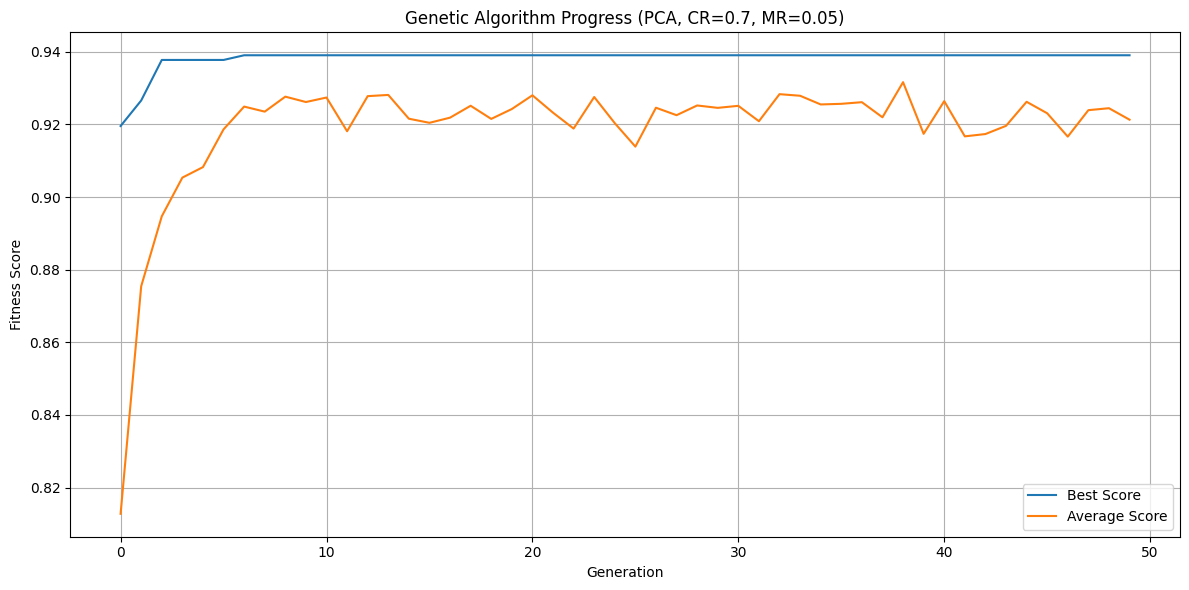

Number of selected PCA components: 10
Selected components:
  1. PCA_Component_1
  2. PCA_Component_3
  3. PCA_Component_4
  4. PCA_Component_5
  5. PCA_Component_9
  6. PCA_Component_10
  7. PCA_Component_11
  8. PCA_Component_12
  9. PCA_Component_13
  10. PCA_Component_15

Best cross-validation score: 0.9391

Training ensemble model on selected features...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │      2,816 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_24 (Lambda)  │ (None, 10, 1)     │          0 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │        225 │ lambda_24[0][0],  │
│ (MultiHeadAttentio… │                   │            │ lambda_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_fm_3 (DeepFM)  │ (None, 1)         │         80 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 10)        │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LNN_output (Dense)  │ (None, 1)         │         11 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DNN_output (Dense)  │ (None, 1)         │        129 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DeepFM_output       │ (None, 1)         │          2 │ deep_fm_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ factorization_mach… │ (None, 1)         │         80 │ input_features[0… │
│ (FactorizationMach… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Autoint_output      │ (None, 1)         │         11 │ flatten_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ensemble_concat     │ (None, 5)         │          0 │ LNN_output[0][0], │
│ (Concatenate)       │                   │            │ DNN_output[0][0], │
│                     │                   │            │ DeepFM_output[0]… │
│                     │                   │            │ factorization_ma… │
│                     │                   │            │ Autoint_output[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │          6 │ ensemble_concat[… │
│ (Dense)             │                   │            │                 

 Total params: 37,792 (147.62 KB)

 Trainable params: 37,024 (144.62 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4947 - loss: 2.5031 - val_accuracy: 0.4333 - val_loss: 2.0290
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6046 - loss: 1.9900 - val_accuracy: 0.4333 - val_loss: 1.8678
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7081 - loss: 1.5983 - val_accuracy: 0.6000 - val_loss: 1.7363
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7414 - loss: 1.3065 - val_accuracy: 0.6667 - val_loss: 1.6299
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7769 - loss: 1.0126 - val_accuracy: 0.7000 - val_loss: 1.5059
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7763 - loss: 0.7653 - val_accuracy: 0.6667 - val_loss: 1.4167
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8032 - loss: 0.5625 - val_accuracy: 0.7667 - val_loss: 1.4612
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8376 - loss: 0.4243 - val_accuracy: 0.7667 - val_loss

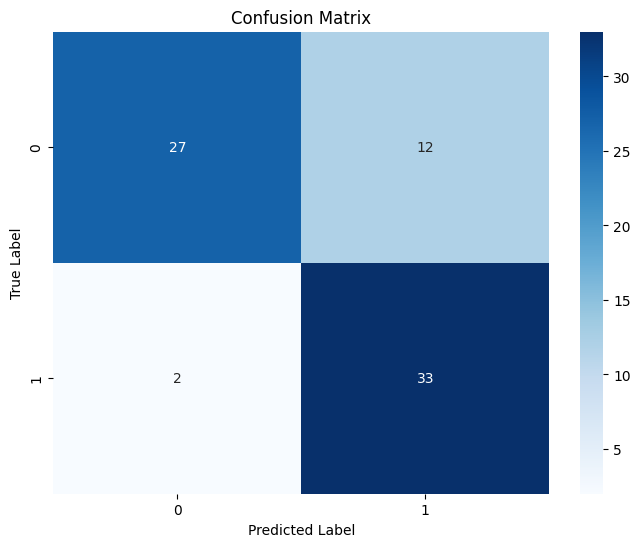

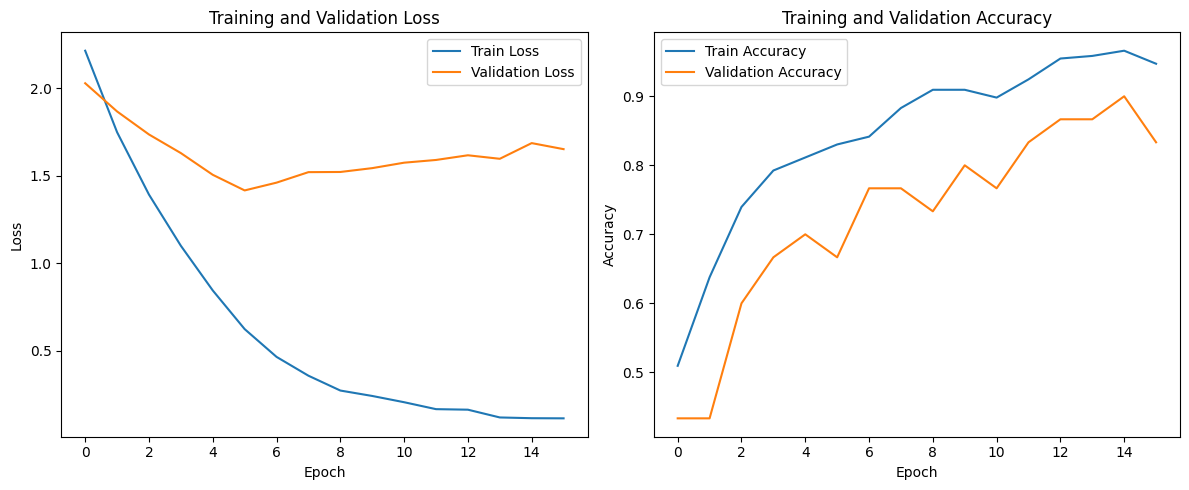


Pipeline completed successfully!


In [210]:
# -------------------------
# Entry Point
# -------------------------
if __name__ == "__main__":
    target_col = input(
        "Enter the target column name (default: 'Overall Survival Status'): ") or "therapy_response"
    results = main(df, target_col=target_col)

    print("\nPipeline completed successfully!")

## ELITE GARP

In [211]:
X = df.drop(columns=["therapy_response"])
y = df["therapy_response"].values

In [212]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

In [213]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, MultiHeadAttention, Lambda
from tensorflow.keras.optimizers import Adam

In [214]:
def preprocess_data(df, target_col):
    print(f"Dataset shape: {df.shape}")
    print("Target variable distribution:")
    print(df[target_col].value_counts())

    X = df.drop(columns=[target_col])
    if 'remainder__Overall Survival (Months)' in X.columns:
        X = X.drop(columns=['remainder__Overall Survival (Months)'])
    y = df[target_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

In [215]:
def perform_genetic_pca(X_scaled, y, random_state):
    ga = GeneticFeatureExtraction(
        X=X_scaled,
        y=y,
        n_components=min(20, X_scaled.shape[1]),
        population_size=50,
        generations=50,
        crossover_rate=0.7,
        mutation_rate=0.05,
        elite_size=3,
        model=LogisticRegression(
            C=0.1, class_weight='balanced', random_state=random_state, max_iter=1000),
        cv=5
    )

    results = ga.run()
    ga.plot_progress()

    selected_features = results['selected_features']
    feature_names = results['selected_feature_names']
    print("Selected Features:", feature_names)

    if ga.extractor:
        X_pca = ga.extractor.transform(X_scaled)
        X_selected = X_pca[:, selected_features]
    else:
        X_selected = X_scaled[:, selected_features]

    return X_selected, selected_features, feature_names, results['best_score'], ga.pca_loadings,ga.X_for_selection,ga.features

In [216]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Compute class weights
cw = class_weight.compute_class_weight(
    'balanced', classes=np.array([0, 1]), y=y_train)
class_weights_dict = {0: cw[0], 1: cw[1]}

# Train Classical Models


def train_classical_models(X_train, y_train, X_test):
    models = {
        'rf': RandomForestClassifier(n_estimators=100),
        'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'lgb': LGBMClassifier(),
        'lr': LogisticRegression()
    }

    predictions = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions[name] = model.predict_proba(X_test)[:, 1]

    return models, predictions

In [217]:
def build_dnn_branch(input_layer):
    x = Dense(128, activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return Dense(1, activation='sigmoid', name='dnn_output')(x)


def build_autoint_branch(input_tensor, num_heads=4, key_dim=8):
    x = Lambda(lambda t: tf.expand_dims(t, axis=-1))(input_tensor)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Flatten()(x)
    return Dense(1, activation='sigmoid', name='autoint_output')(x)

In [218]:
def train_neural_model(X_train, y_train, X_test):
    input_layer = Input(shape=(X_train.shape[1],))
    dnn_out = build_dnn_branch(input_layer)
    autoint_out = build_autoint_branch(input_layer)

    model = Model(inputs=input_layer, outputs=[dnn_out, autoint_out])
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[['accuracy'], ['accuracy']])

    history = model.fit(X_train, [y_train, y_train],
                        validation_split=0.1,
                        epochs=30,
                        batch_size=32,
                        verbose=1)

    dnn_preds, autoint_preds = model.predict(X_test)
    return model, history.history, dnn_preds.ravel(), autoint_preds.ravel()

In [219]:
def train_meta_learner(pred_dict, dnn_preds, autoint_preds, y_test):
    ensemble_input = np.column_stack([
        pred_dict['rf'], pred_dict['xgb'], pred_dict['lgb'], pred_dict['lr'],
        dnn_preds, autoint_preds
    ])

    meta_model = LogisticRegression()
    meta_model.fit(ensemble_input, y_test)
    final_preds = meta_model.predict(ensemble_input)
    return meta_model, final_preds

In [220]:
def visualize_training(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['dnn_output_accuracy'], label='DNN Train Acc')
    plt.plot(history['val_dnn_output_accuracy'], label='DNN Val Acc')
    plt.plot(history['autoint_output_accuracy'], label='AutoInt Train Acc')
    plt.plot(history['val_autoint_output_accuracy'], label='AutoInt Val Acc')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [221]:
def run_full_ensemble(df, target_col, random_state=42):
    np.random.seed(random_state)
    random.seed(random_state)
    tf.random.set_seed(random_state)

    X_scaled, y = preprocess_data(df, target_col)
    X_selected, selected_features, feature_names, best_score, pca_loadings, X_for_selection, features = perform_genetic_pca(
        X_scaled, y, random_state)

    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=random_state)

    classical_models, classical_preds = train_classical_models(
        X_train, y_train, X_test)
    nn_model, history, dnn_preds, autoint_preds = train_neural_model(
        X_train, y_train, X_test)

    meta_learner, final_preds = train_meta_learner(
        classical_preds, dnn_preds, autoint_preds, y_test)

    acc = accuracy_score(y_test, final_preds)
    auc = roc_auc_score(y_test, final_preds)

    print(f"\nEnsemble Accuracy: {acc:.4f}")
    print(f"Ensemble AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, final_preds))
    f1score = f1_score(y_test, final_preds)

    visualize_training(history)
    plot_confusion_matrix(y_test, final_preds)

    return {
        'meta_learner': meta_learner,
        'classical_models': classical_models,
        'nn_model': nn_model,
        'ensemble_acc': acc,
        'ensemble_auc': auc,
        'selected_features': selected_features,
        'feature_names': feature_names,
        'history': history,
        "pca_loading": pca_loadings,
        "X_for_selection": X_for_selection,
        "features": features,
        "f1_score": f1score
    }

Dataset shape: (369, 39)
Target variable distribution:
therapy_response
0.0    188
1.0    181
Name: count, dtype: int64
Performing PCA feature extraction...
PCA: Extracted 20 components explaining 94.87% of variance
Generation 1/50, Best Score: 0.9525
Generation 10/50, Best Score: 0.9691
Generation 20/50, Best Score: 0.9749
Generation 30/50, Best Score: 0.9772
Generation 40/50, Best Score: 0.9772
Generation 50/50, Best Score: 0.9772


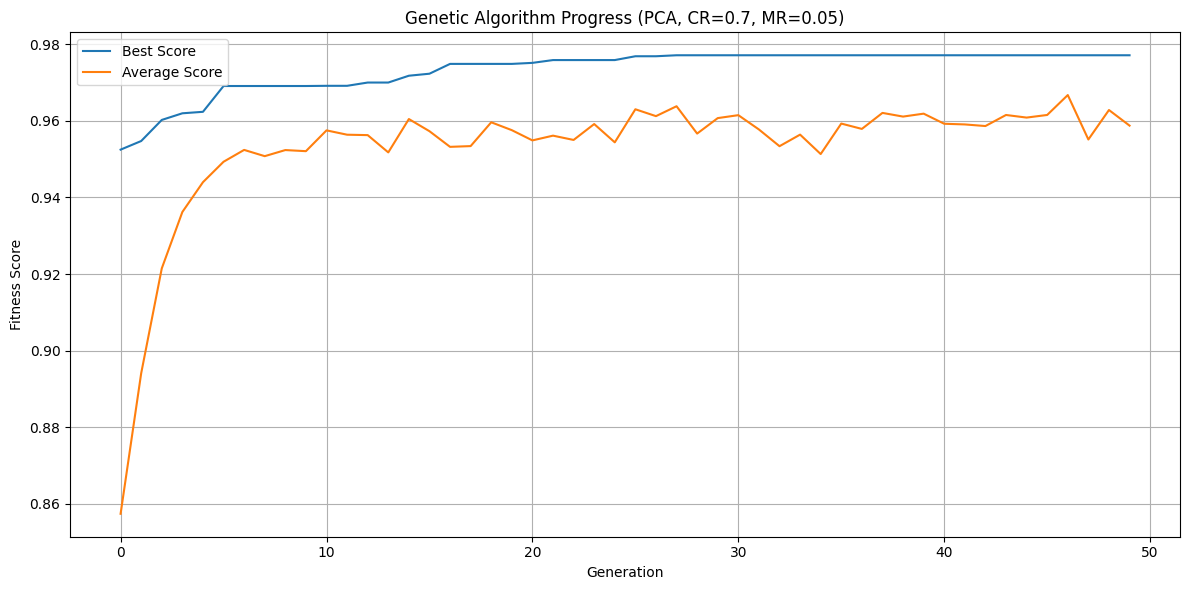

Selected Features: ['PCA_Component_4', 'PCA_Component_8', 'PCA_Component_9', 'PCA_Component_11', 'PCA_Component_12', 'PCA_Component_13', 'PCA_Component_14', 'PCA_Component_15', 'PCA_Component_16', 'PCA_Component_18', 'PCA_Component_19', 'PCA_Component_20']
[LightGBM] [Info] Number of positive: 146, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494915 -> initscore=-0.020340
[LightGBM] [Info] Start training from score -0.020340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:52:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - autoint_output_accuracy: 0.4856 - autoint_output_loss: 0.8111 - dnn_output_accuracy: 0.6314 - dnn_output_loss: 0.7731 - loss: 1.5807 - val_autoint_output_accuracy: 0.5333 - val_autoint_output_loss: 0.7275 - val_dnn_output_accuracy: 0.7333 - val_dnn_output_loss: 0.6628 - val_loss: 1.3903
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - autoint_output_accuracy: 0.4748 - autoint_output_loss: 0.7701 - dnn_output_accuracy: 0.8091 - dnn_output_loss: 0.4669 - loss: 1.2390 - val_autoint_output_accuracy: 0.5667 - val_autoint_output_loss: 0.6945 - val_dnn_output_accuracy: 0.8000 - val_dnn_output_loss: 0.5796 - val_loss: 1.2741
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - autoint_output_accuracy: 0.4770 - autoint_output_loss: 0.7426 - dnn_output_accuracy: 0.8616 - dnn_output_loss: 0.3505 - loss: 1.0938 - val_autoint_output_accuracy: 0.5667 - val_autoint_output_loss: 0.6785 - val_dnn_output_accuracy: 0.8333 - val_dnn_output_loss: 0.5208 - val_loss: 1

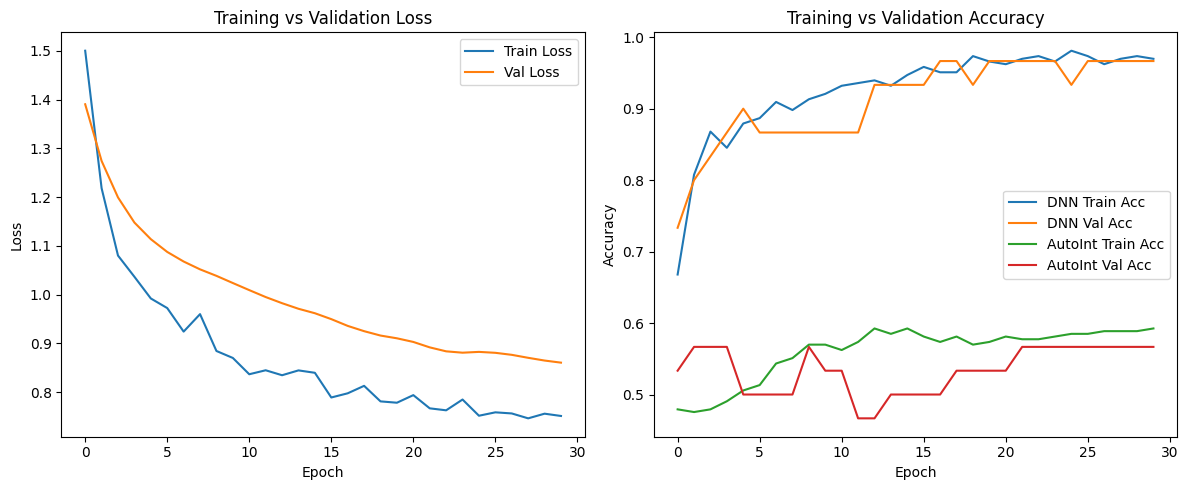

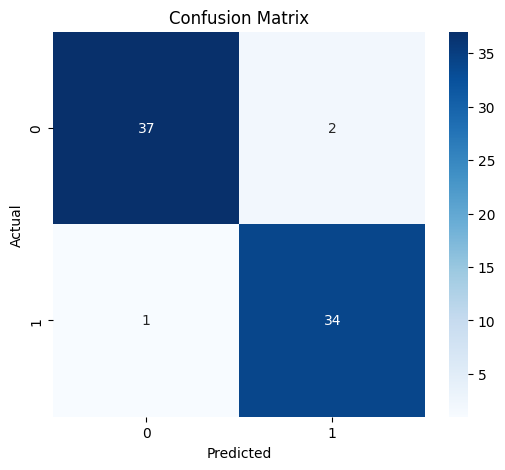


Ensemble model results:
Accuracy: 0.9595
AUC: 0.9601
f1 Score: 0.9577464788732394
Selected features: ['PCA_Component_4', 'PCA_Component_8', 'PCA_Component_9', 'PCA_Component_11', 'PCA_Component_12', 'PCA_Component_13', 'PCA_Component_14', 'PCA_Component_15', 'PCA_Component_16', 'PCA_Component_18', 'PCA_Component_19', 'PCA_Component_20']


In [222]:
results_ensemble = run_full_ensemble(df, target_col)
print("\nEnsemble model results:")
print(f"Accuracy: {results_ensemble['ensemble_acc']:.4f}")
print(f"AUC: {results_ensemble['ensemble_auc']:.4f}")
print("f1 Score:", results_ensemble['f1_score'])
print("Selected features:", results_ensemble['feature_names'])

## PCA BackMapping Visualization

In [223]:
feature_names = results_ensemble['feature_names']
feature_names = [i.replace("A_Component_", "") for i in feature_names]
pca_loadings = results_ensemble["pca_loading"]
pca_loadings_df = pd.DataFrame(pca_loadings, columns=feature_names)

In [224]:
pca_loadings_df = pca_loadings_df.T

In [225]:
def plot_selected_pca_heatmap(pca_loadings_df, top_n_features):
    """
    Plots a heatmap of PCA loadings for selected principal components.
    
    Args:
        pca_loadings_df (pd.DataFrame): DataFrame with PCs as index and original features as columns (transpose if needed).
        top_n_features (int): Number of top contributing features to display.
    """
    # Transpose to get features as index (rows)
    if pca_loadings_df.shape[0] < pca_loadings_df.shape[1]:  # assume PCs as rows
        pca_loadings_df = pca_loadings_df.T

    # Compute overall contribution per feature
    contribution_scores = pca_loadings_df.abs().sum(axis=1)

    # Select top features
    top_features = contribution_scores.sort_values(
        ascending=False).head(top_n_features).index

    # Subset for heatmap
    heatmap_data = pca_loadings_df.loc[top_features]

    # Plot
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',
                center=0, fmt=".3f", linewidths=0.5)
    plt.title(
        f'PCA Loadings Heatmap (Top {top_n_features} Features)', fontsize=14)
    plt.xlabel('Principal Components')
    plt.ylabel('Original Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

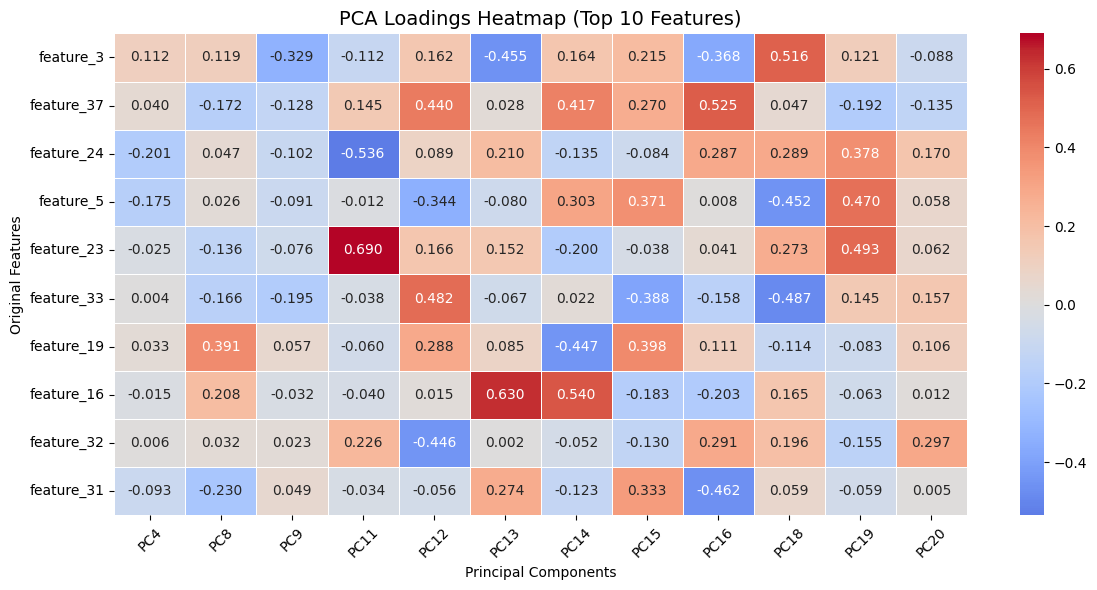

In [226]:
plot_selected_pca_heatmap(pca_loadings_df, top_n_features=10)

In [227]:
real_features = df.columns.tolist()
feature_col_num = pca_loadings_df.columns.tolist()

In [228]:
# Dictionary to map PCA components to original features
pca_to_features = {}

for i in range(len(feature_col_num)):
    pca_to_features[feature_col_num[i]] = real_features[i]

## Explanability of ELITE GARP Model

In [229]:
# Get predictions from individual models
ensemble_input = np.column_stack([
    results_ensemble['classical_models']['rf'].predict_proba(
        X_test[:, results_ensemble['selected_features']])[:, 1],
    results_ensemble['classical_models']['xgb'].predict_proba(
        X_test[:, results_ensemble['selected_features']])[:, 1],
    results_ensemble['classical_models']['lgb'].predict_proba(
        X_test[:, results_ensemble['selected_features']])[:, 1],
    results_ensemble['classical_models']['lr'].predict_proba(
        X_test[:, results_ensemble['selected_features']])[:, 1],
    results_ensemble['nn_model'].predict(
        X_test[:, results_ensemble['selected_features']])[0].ravel(),  # DNN predictions
    results_ensemble['nn_model'].predict(X_test[:, results_ensemble['selected_features']])[
        1].ravel()   # AutoInt predictions
])

c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\prans\AppData\Local\Temp\ipykernel_22380\2142289594.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], features=ensemble_input,


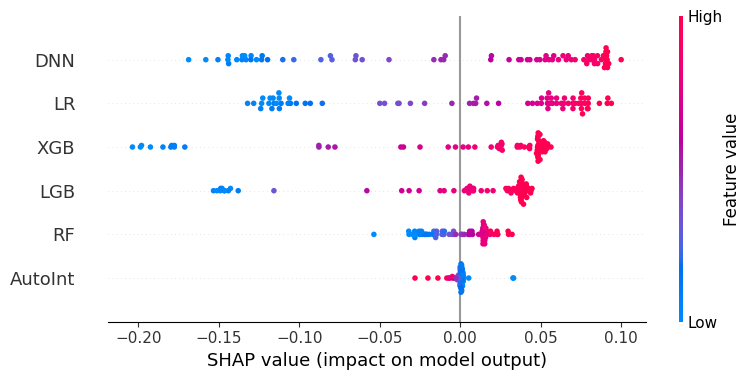

In [230]:
import shap

explainer = shap.Explainer(results_ensemble["meta_learner"].predict_proba, ensemble_input)
shap_values = explainer(ensemble_input)

shap.summary_plot(shap_values[:, :, 1], features=ensemble_input,
                  feature_names=['RF', 'XGB', 'LGB', 'LR', 'DNN', 'AutoInt'])

## Explanability For Each Model Seperately

### Random Forest

PermutationExplainer explainer: 75it [00:19,  2.22it/s]                        
C:\Users\prans\AppData\Local\Temp\ipykernel_22380\1039536212.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1],


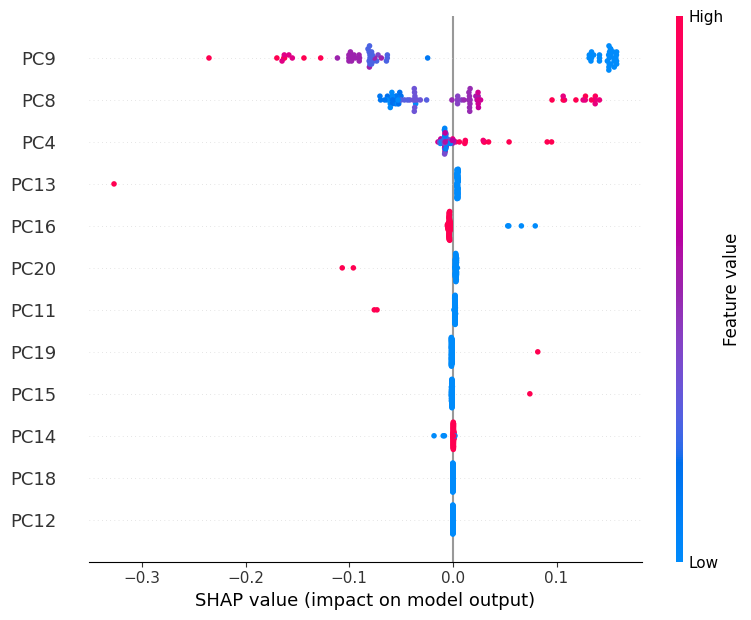

In [231]:
import shap

# Get the trained model
rf_model = results_ensemble['classical_models']['rf']

# Use the PCA-selected features (X_selected) — must match what model saw
X_test_selected = X_test[:, results_ensemble['selected_features']]
explainer = shap.Explainer(rf_model.predict_proba, X_test_selected)
shap_values = explainer(X_test_selected)

# Optional: Visualize SHAP on PCA components
shap.summary_plot(shap_values[:, :, 1],
                  features=X_test_selected, feature_names=feature_names)

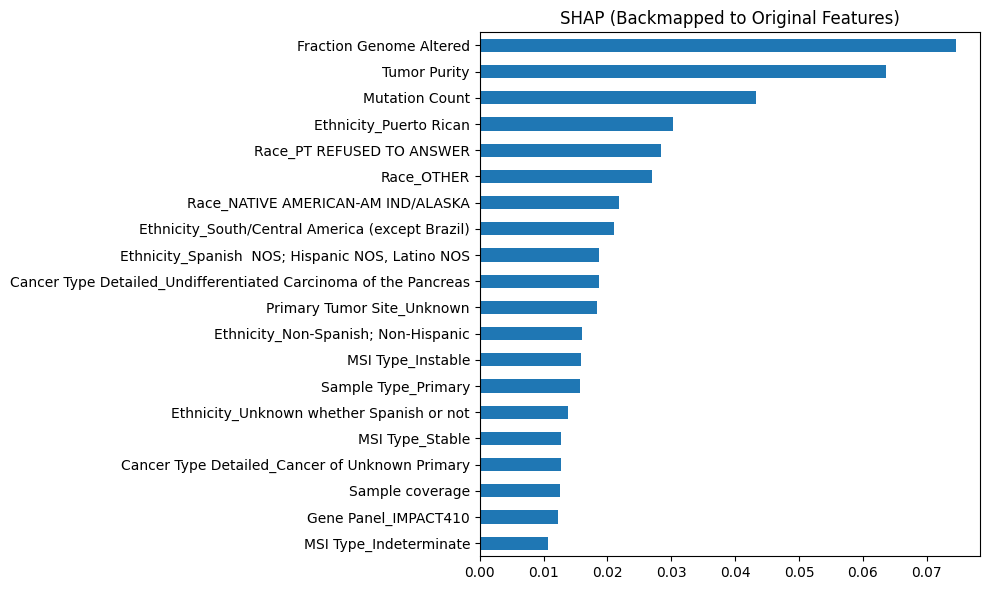

In [232]:
# Get SHAP values for the positive class (class 1)
shap_array = shap_values.values[:, :, 1]  # shape: (n_samples, n_components)

# Convert to DataFrame for matrix multiplication
# feature_names are PCs like "feature_0"
shap_df = pd.DataFrame(shap_array, columns=feature_names)

# Backmap to original features using PCA loadings
# shape: (n_samples, original_features)
backmapped_shap = shap_df @ pca_loadings_df

# Compute mean absolute SHAP values per original feature
mean_abs_shap = backmapped_shap.abs().mean().sort_values(ascending=False)

# Map feature names using pca_to_features dictionary
mean_abs_shap.index = mean_abs_shap.index.map(
    lambda x: pca_to_features.get(x, x))  # use original names if available

# Plot the top 20 features
mean_abs_shap.head(20).plot(
    kind='barh',
    figsize=(10, 6),
    title="SHAP (Backmapped to Original Features)"
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### XGB Model

C:\Users\prans\AppData\Local\Temp\ipykernel_22380\2949945726.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1],


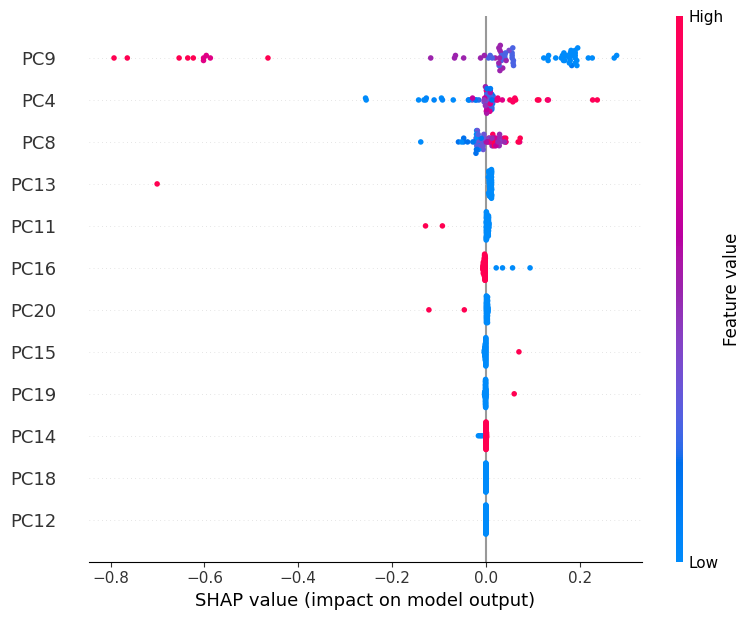

In [233]:
import shap

# Get the trained model
rf_model = results_ensemble['classical_models']['xgb']

# Use the PCA-selected features (X_selected) — must match what model saw
X_test_selected = X_test[:, results_ensemble['selected_features']]
explainer = shap.Explainer(rf_model.predict_proba, X_test_selected)
shap_values = explainer(X_test_selected)

# Optional: Visualize SHAP on PCA components
shap.summary_plot(shap_values[:, :, 1],
                  features=X_test_selected, feature_names=feature_names)

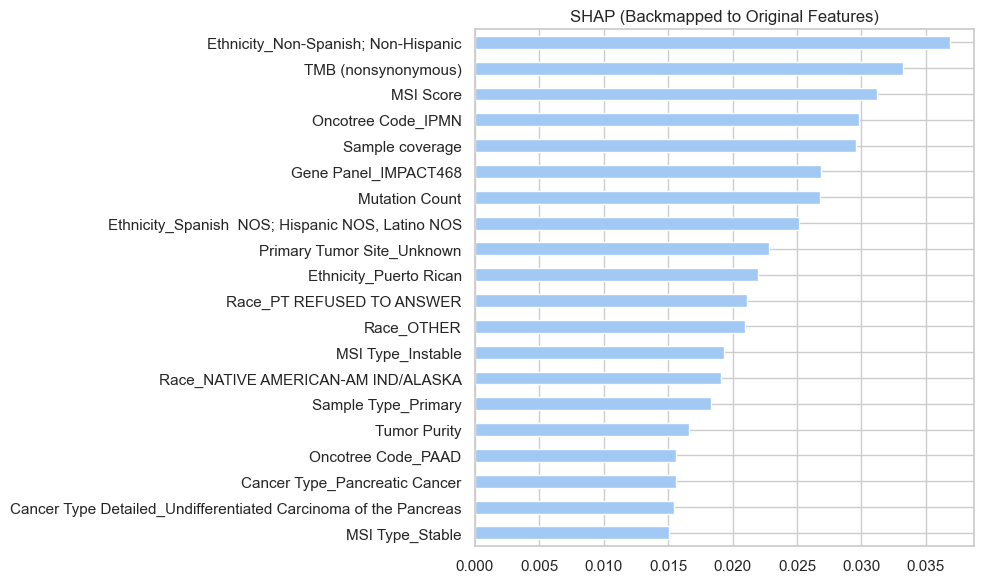

In [ ]:
# Get SHAP values for the positive class (class 1)
shap_array = shap_values.values[:, :, 1]  # shape: (n_samples, n_components)

# Convert to DataFrame for matrix multiplication
# feature_names are PCs like "feature_0"
shap_df = pd.DataFrame(shap_array, columns=feature_names)

# Backmap to original features using PCA loadings
# shape: (n_samples, original_features)
backmapped_shap = shap_df @ pca_loadings_df

# Compute mean absolute SHAP values per original feature
mean_abs_shap = backmapped_shap.abs().mean().sort_values(ascending=False)

# Map feature names using pca_to_features dictionary
mean_abs_shap.index = mean_abs_shap.index.map(
    lambda x: pca_to_features.get(x, x))  # use original names if available

# Plot the top 20 features
mean_abs_shap.head(20).plot(
    kind='barh',
    figsize=(10, 6),
    title="SHAP (Backmapped to Original Features)"
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Logistic Regression

C:\Users\prans\AppData\Local\Temp\ipykernel_22380\639773476.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1],


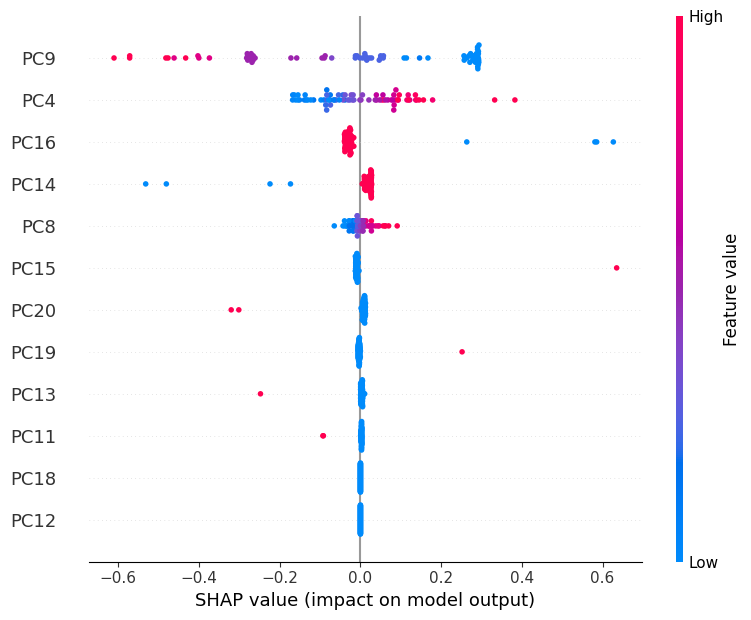

In [235]:
import shap

# Get the trained model
rf_model = results_ensemble['classical_models']['lr']

# Use the PCA-selected features (X_selected) — must match what model saw
X_test_selected = X_test[:, results_ensemble['selected_features']]
explainer = shap.Explainer(rf_model.predict_proba, X_test_selected)
shap_values = explainer(X_test_selected)

# Optional: Visualize SHAP on PCA components
shap.summary_plot(shap_values[:, :, 1],
                  features=X_test_selected, feature_names=feature_names)

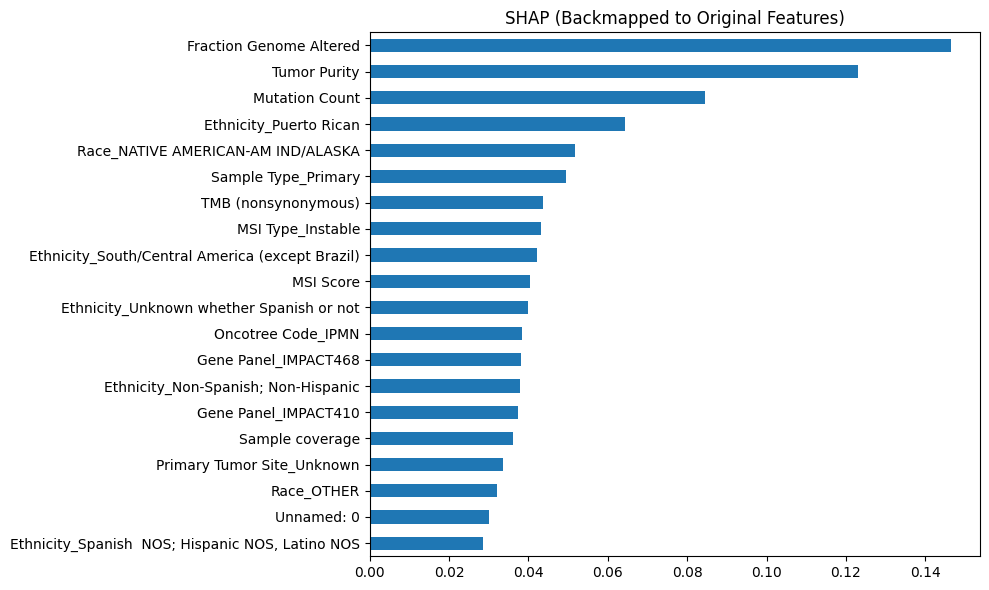

In [236]:
# Get SHAP values for the positive class (class 1)
shap_array = shap_values.values[:, :, 1]  # shape: (n_samples, n_components)

# Convert to DataFrame for matrix multiplication
# feature_names are PCs like "feature_0"
shap_df = pd.DataFrame(shap_array, columns=feature_names)

# Backmap to original features using PCA loadings
# shape: (n_samples, original_features)
backmapped_shap = shap_df @ pca_loadings_df

# Compute mean absolute SHAP values per original feature
mean_abs_shap = backmapped_shap.abs().mean().sort_values(ascending=False)

# Map feature names using pca_to_features dictionary
mean_abs_shap.index = mean_abs_shap.index.map(
    lambda x: pca_to_features.get(x, x))  # use original names if available

# Plot the top 20 features
mean_abs_shap.head(20).plot(
    kind='barh',
    figsize=(10, 6),
    title="SHAP (Backmapped to Original Features)"
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: U

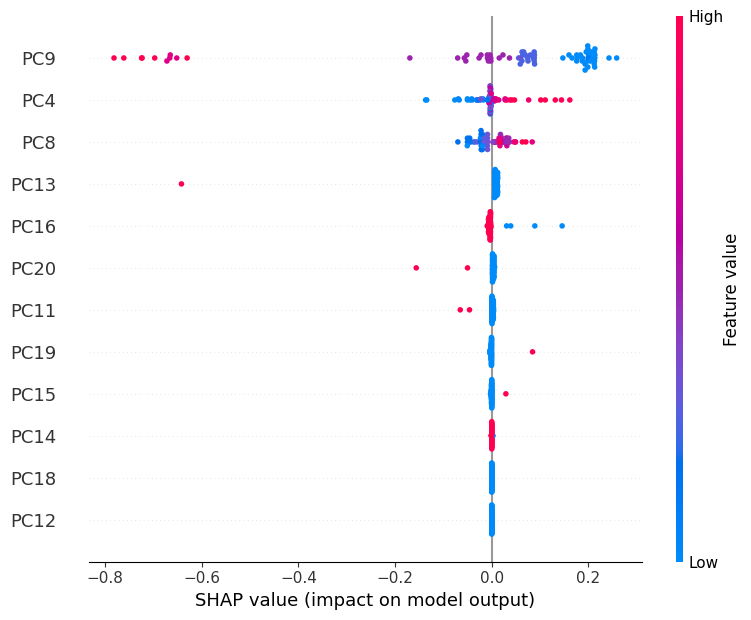

In [237]:
import shap

# Get the trained model
rf_model = results_ensemble['classical_models']['lgb']

# Use the PCA-selected features (X_selected) — must match what model saw
X_test_selected = X_test[:, results_ensemble['selected_features']]
explainer = shap.Explainer(rf_model.predict_proba, X_test_selected)
shap_values = explainer(X_test_selected)

# Optional: Visualize SHAP on PCA components
shap.summary_plot(shap_values[:, :, 1],
                  features=X_test_selected, feature_names=feature_names)

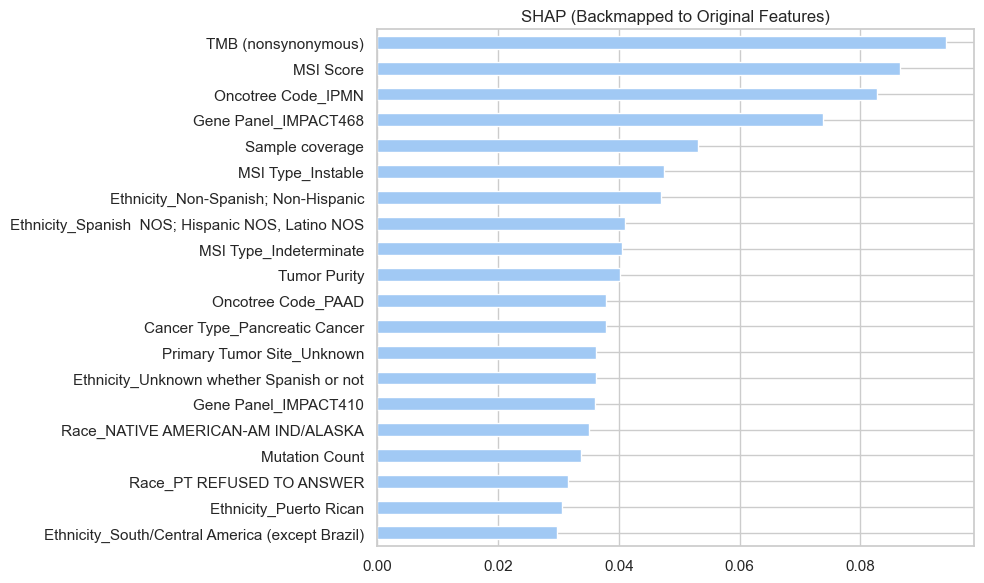

In [ ]:
# Get SHAP values for the positive class (class 1)
shap_array = shap_values.values[:, :, 1]  # shape: (n_samples, n_components)

# Convert to DataFrame for matrix multiplication
# feature_names are PCs like "feature_0"
shap_df = pd.DataFrame(shap_array, columns=feature_names)

# Backmap to original features using PCA loadings
# shape: (n_samples, original_features)
backmapped_shap = shap_df @ pca_loadings_df

# Compute mean absolute SHAP values per original feature
mean_abs_shap = backmapped_shap.abs().mean().sort_values(ascending=False)

# Map feature names using pca_to_features dictionary
mean_abs_shap.index = mean_abs_shap.index.map(
    lambda x: pca_to_features.get(x, x))  # use original names if available

# Plot the top 20 features
mean_abs_shap.head(20).plot(
    kind='barh',
    figsize=(10, 6),
    title="SHAP (Backmapped to Original Features)"
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()